In [1]:
library(ggplot2)
library(tidyr)
library(gridExtra)

Let us consider a random sample of n_sample numbers from normal distribution with mu = mean_actual and sigma-square = variance_actual parameters.

In [2]:
n_sample <- 10000
n_trial <- 100

mean_confidence <- 0.95
variance_confidence <- 0.95

In [3]:
mean_actual <- 5.0
variance_actual <- 2.0
poiss_lambda <- 3.0
stddev_actual <- sqrt(variance_actual)

We would like to estimate those actual parameters in terms of interval estimation, basing on a sample.

A sample mean interval estimator is given as a following function:

In [4]:
mean_interval_estimator <- function(sample, confidence_level = mean_confidence) {
    mean_estimator <- mean(sample)
    std_dev_estimator <- sd(sample)
    
    alpha <- 1 - confidence_level
    
    student_quantile <- qt(1 - alpha / 2, n_sample-1)
    
    mean_confidence <- c(
        mean_estimator - student_quantile * std_dev_estimator / sqrt(n_sample - 1), 
        mean_estimator + student_quantile * std_dev_estimator / sqrt(n_sample - 1)
    )
    
    return(mean_confidence)
}

A sample variance interval estimator is given as a following function:

In [5]:
variance_interval_estimator <- function(sample, confidence_level = variance_confidence) {
    variance_estimator <- var(sample)
    
    alpha <- 1 - confidence_level
    
    chisq_left_quantile <- qchisq(1 - alpha / 2, n_sample - 1)
    chisq_right_quantile <- qchisq(alpha / 2, n_sample - 1)
    
    variance_confidence <- c(
        (n_sample-1) * variance_estimator / chisq_left_quantile,
        (n_sample-1) * variance_estimator / chisq_right_quantile
    )
    
    return(variance_confidence)
}

Let us generate an n_trials number of samples taken from distribution described above:

In [6]:
generate_samples_normal <- function() {
    data_frame <- data.frame(
        matrix(
            rnorm(n_sample * n_trial, mean_actual, stddev_actual), 
            nrow = n_sample
        )
    )
    
    return(data_frame)
}

In [7]:
generate_samples_poiss <- function() {
    data_frame <- data.frame(
        matrix(
            rpois(n_sample * n_trial, lambda = poiss_lambda),
            nrow = n_sample
        )
    )
    
    return(data_frame)
}

In [8]:
data_frame <- generate_samples_poiss()

Process the data frame to plot the approximate probability densities for particular samples (skipped if there are more than 100 trials due to optimization issues): 

In [9]:
if(n_trial < 100) {
    data_frame_tidy <- gather(data_frame, cols, value) 
    ggplot(data_frame_tidy, aes(x = value)) + geom_density(aes(color=cols))
}

Compute the mean value point estimates and confidence intervals for each sample and gather results in the data frame:

In [10]:
mean_interval_df <- function(data_frame) {

    mean_frame = data.frame(
        trial = 1:n_trial,
        mean = apply(data_frame, 2, mean),
        mean_low = apply(data_frame, 2, mean_interval_estimator)[1,],
        mean_high = apply(data_frame, 2, mean_interval_estimator)[2,]
    )

    return(mean_frame)
}

In [11]:
mean_frame <- mean_interval_df(data_frame)

Plot the estimates and compare it with actual mean value:

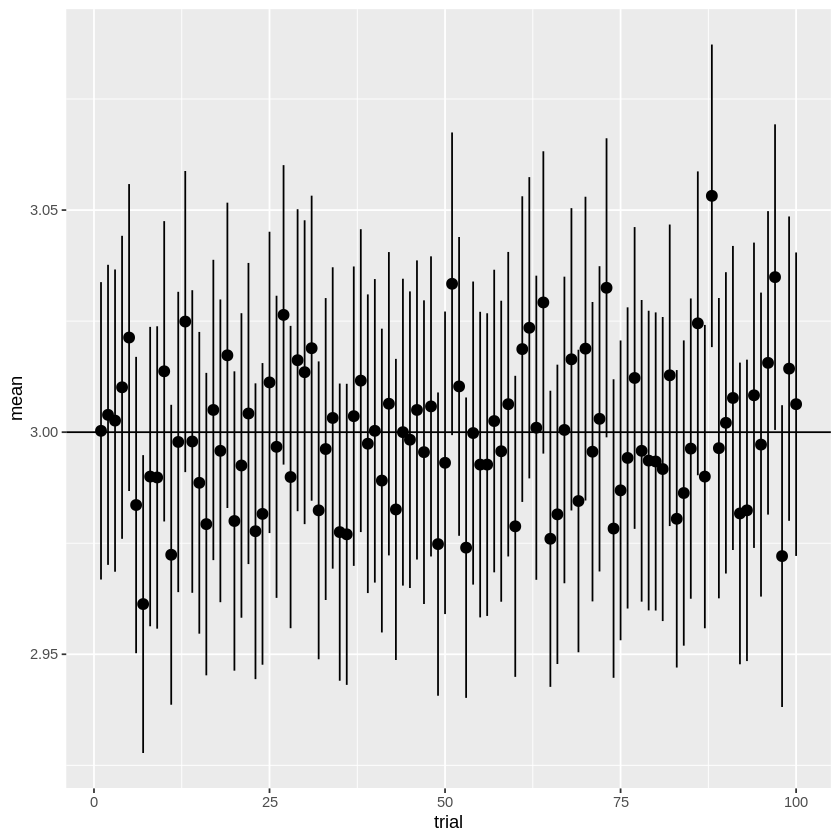

In [12]:
mean_interval_plot <- function(mean_frame, line_intercept) { 

    mean_plot <- ggplot() +  
    geom_pointrange(
        data = mean_frame,
        mapping = aes(
            x = trial,
            y = mean,
            ymin = mean_low,
            ymax = mean_high
        )
    ) + 
    geom_abline(
        aes(
            intercept = line_intercept, 
            slope = 0
        )
    )
    
    return(mean_plot)
}

mean_plot <- mean_interval_plot(mean_frame, poiss_lambda)

mean_plot

Compute the variance point estimates and confidence intervals for each sample and gather results in the data frame:

In [13]:
variance_interval_df <- function(data_frame) {

    var_frame = data.frame(
        trial = 1:n_trial,
        variance = apply(data_frame, 2, var),
        var_low = apply(data_frame, 2, variance_interval_estimator)[1,],
        var_high = apply(data_frame, 2, variance_interval_estimator)[2,]
    )

    return(var_frame)
}

In [14]:
var_frame <- variance_interval_df(data_frame)

Plot the estimates and compare it with actual variance:

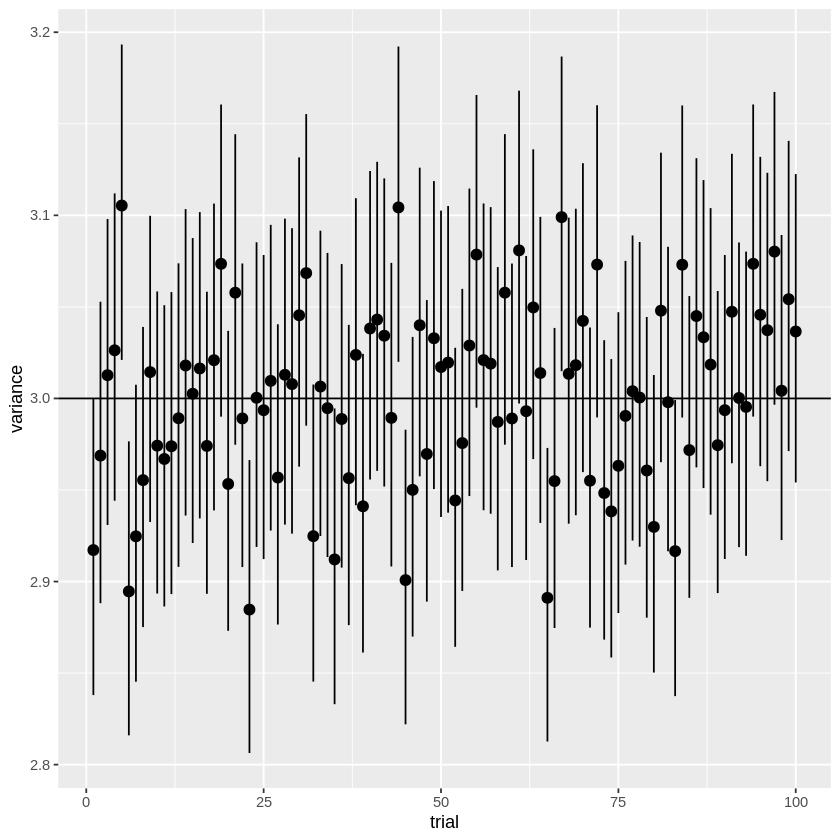

In [15]:
variance_interval_plot <- function(var_frame, line_intercept) {
    var_plot <- ggplot() +  
    geom_pointrange(
        data = var_frame,
        mapping = aes(
            x = trial,
            y = variance,
            ymin = var_low,
            ymax = var_high
        )
    ) + 
    geom_abline(
        aes(
            intercept = line_intercept,
            slope = 0
        )
    )

    return(var_plot)
}

var_plot <- variance_interval_plot(var_frame, poiss_lambda)

var_plot

In [16]:
filename <- "result"

In [17]:
plot_grob <- arrangeGrob(mean_plot, var_plot, nrow=2)
ggsave(
    file = paste(filename, ".pdf"),
    plot_grob
)

ggsave(
    file = paste(filename, ".eps"),
    plot_grob
)

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In [21]:
n_sample <- 10

normal_small_df <- generate_samples_normal()
normal_small_mean_df <- mean_interval_df(normal_small_df)
normal_small_mean_plot <- mean_interval_plot(normal_small_mean_df, mean_actual)
normal_small_var_df <- variance_interval_df(normal_small_df)
normal_small_var_plot <- variance_interval_plot(normal_small_var_df, variance_actual)

n_sample <- 10000

normal_large_df <- generate_samples_normal()
normal_large_mean_df <- mean_interval_df(normal_large_df)
normal_large_mean_plot <- mean_interval_plot(normal_large_mean_df, mean_actual)
normal_large_var_df <- variance_interval_df(normal_large_df)
normal_large_var_plot <- variance_interval_plot(normal_large_var_df, variance_actual)

poiss_large_df <- generate_samples_poiss()
poiss_large_mean_df <- mean_interval_df(poiss_large_df)
poiss_large_mean_plot <- mean_interval_plot(poiss_large_mean_df, poiss_lambda)
poiss_large_var_df <- variance_interval_df(poiss_large_df)
poiss_large_var_plot <- variance_interval_plot(poiss_large_var_df, poiss_lambda)

plot_grob <- arrangeGrob(
    normal_small_mean_plot, normal_large_mean_plot, poiss_large_mean_plot, 
    normal_small_var_plot, normal_large_var_plot, poiss_large_var_plot,
    ncol = 3,
    nrow = 2,
    widths = c(3000, 3000, 3000),
    heights = c(3000, 3000),
    respect = TRUE
)

ggsave(
    file = "collective.pdf",
    plot_grob,
    width = 20,
    height = 14
)

ggsave(
    file = "collective.eps",
    plot_grob,
    width = 20,
    height = 14
)

In [22]:
ggsave(
    file = "collective.png",
    plot_grob,
    width = 20,
    height = 14
)